In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

C:\Users\rdua3651\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\rdua3651\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\rdua3651\Anaconda3\lib\site-packages\sklearn\learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationW

In [3]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [4]:
def haverSin (theta):
    v = math.sin (theta/2.0)
    return v*v

def calDistFromLonLat (LonAR, LatAR, LonBR, LatBR):
    earthRadius = 6370.0004

    LonA = math.radians (LonAR)
    LatA = math.radians (LatAR)
    LonB = math.radians (LonBR)
    LatB = math.radians (LatBR)

    vLon = abs(LonA - LonB)
    vLat = abs(LatA - LatB)

    h = haverSin (vLat) + math.cos(LatA) * math.cos(LatB) * haverSin(vLon)

    distance = 2*earthRadius * math.asin (math.asin(math.sqrt(h)))

    return distance


In [5]:
#circular quary
cen_lon = 151.210779
cen_lat = -33.861332

In [6]:
data=pd.read_csv('train.csv', index_col = "Id")

In [7]:
data.head()

,price,host_is_superhost,host_total_listings_count,host_identity_verified,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,reviews_per_month
Id,,,,,,,,,,,,,,,,,,,,,
0,150,f,22.0,t,-33.846469,151.205171,Apartment,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,strict,0.53
1,66,f,1.0,t,-33.895736,151.173529,Apartment,Private room,2,1.5,...,NaN,NaN,NaN,NaN,NaN,NaN,f,f,flexible,NaN
2,325,t,1.0,t,-33.879322,151.222408,House,Entire home/apt,4,2.0,...,10.0,10.0,10.0,10.0,10.0,9.0,f,f,moderate,2.38
3,145,f,1.0,f,-33.856874,151.149600,House,Entire home/apt,6,1.5,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,flexible,1.96
4,200,f,6.0,t,-33.907150,151.178552,House,Entire home/apt,4,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,f,f,moderate,2.73


In [8]:
def show_up_percentage(df, column):
    dic = {}
    name = "{}_percent".format(column)
    s = df.shape[0]
    types = df[column].unique()
    df[name] = 0
    
    for t in types:
        count = 0
        for i in range(s):
            if df.loc[i,column] == t:
                count += 1
        dic[t] = count
    
    for key, value in dic.items():
        for i in range(s):
            if df.loc[i,column] == key:
                df.loc[i,name] = value
    
    df[name] = df[name] / s

    return df

data = show_up_percentage(data, "room_type")
# data = show_up_percentage(data, "property_type")

In [9]:
data = pd.get_dummies(data)

In [10]:
data["cen_lon"] = cen_lon
data["cen_lat"] = cen_lat
df_distance = pd.DataFrame(data.apply(lambda x: calDistFromLonLat(x["longitude"], x["latitude"], x["cen_lon"], x["cen_lat"]), axis = 1))
df_distance.rename_axis({0:"distance"}, axis = 1, inplace = True)
data = data.join(df_distance)
data.drop([ "cen_lon", "cen_lat"], axis = 1, inplace = True)
data.head()

,price,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,is_business_travel_ready_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,distance
Id,,,,,,,,,,,,,,,,,,,,,
0,150,22.0,-33.846469,151.205171,2,1.0,1,1.0,500.0,330.0,...,0,0,1,0,1,0,0,0,1,1.731617
1,66,1.0,-33.895736,151.173529,2,1.5,1,1.0,NaN,NaN,...,1,0,1,0,1,0,1,0,0,5.143104
2,325,1.0,-33.879322,151.222408,4,2.0,2,2.0,500.0,180.0,...,0,0,1,0,1,0,0,1,0,2.269938
3,145,1.0,-33.856874,151.149600,6,1.5,3,4.0,0.0,80.0,...,0,0,1,0,1,0,1,0,0,5.669944
4,200,6.0,-33.907150,151.178552,4,1.0,2,2.0,350.0,85.0,...,0,0,1,0,1,0,0,1,0,5.898728


In [11]:
def set_missing_security_deposit(df):
    process = df.drop(["price", "cleaning_fee"], axis = 1)
    temp = process.pop("security_deposit")
    process.fillna(0,inplace = True)
    process.insert(0,"security_deposit", temp)
    know = process[process.security_deposit.notnull()].as_matrix()
    unknow = process[process.security_deposit.isnull()].as_matrix()
    x = know[:,1:]
    y = know[:,0]
    lgbna = lgb.LGBMRegressor(objective='regression', n_estimators = 600, subsample  = 0.8, learning_rate = 0.01)
    lgbna.fit(x,y)
    predicted = lgbna.predict(unknow[:,1:])
    df.loc[(df.security_deposit.isnull()), "security_deposit"] = predicted
    return df

def set_missing_cleaning_fee(df):
    process = df.drop(["price", "security_deposit"], axis = 1)
    temp = process.pop("cleaning_fee")
    process.fillna(0,inplace = True)
    process.insert(0,"cleaning_fee", temp)
    know = process[process.cleaning_fee.notnull()].as_matrix()
    unknow = process[process.cleaning_fee.isnull()].as_matrix()
    x = know[:,1:]
    y = know[:,0]
    lgbna = lgb.LGBMRegressor(objective='regression', n_estimators = 600, subsample  = 0.8, learning_rate = 0.01)
    lgbna.fit(x,y)
    predicted = lgbna.predict(unknow[:,1:])
    df.loc[(df.cleaning_fee.isnull()), "cleaning_fee"] = predicted
    return df
data = set_missing_security_deposit(data)
data = set_missing_cleaning_fee(data)
data.fillna(0, inplace = True)

In [12]:
# data["gap"] = np.sqrt(data["maximum_nights"] - data["minimum_nights"])
data["if_has_review"] = np.where(data["number_of_reviews"] == 0,0,1)
data["bedroom per people"] = data["bedrooms"]/data["accommodates"]
data["bathroom per people"] = data["bathrooms"]/data["accommodates"]
data["beds per people"] = data["beds"] / data["accommodates"]

In [13]:
data["accommodates"] = np.sqrt(data["accommodates"])
data["bathrooms"] = np.sqrt(data["bathrooms"])
data["minimum_nights"] = np.sqrt(data["minimum_nights"])
data["beds"] = np.sqrt(data["beds"])
data["number_of_reviews"] = np.sqrt(data["number_of_reviews"])
data["host_total_listings_count"] = np.sqrt(data["host_total_listings_count"])

In [14]:
def filtering_region(df):
    lat_min = df["latitude"].min()
    lon_min = df["longitude"].min()
    lat_dis = (df["latitude"].max() - df["latitude"].min())/15
    lon_dis = (df["longitude"].max() - df["longitude"].min())/20
    
    region = {}
    i = 1
    for k in range(1,11):
        for j in range(1,21):
            key = "region {}".format(i)
            value = [lat_min + lat_dis*(k - 1), lat_min + lat_dis*k,lon_min + lon_dis*(j - 1), lon_min + lon_dis*j ]
            region[key] = value
            i += 1

    s = df.iloc[:,0].size
    df["region"] = 0
    for i in range(s):
        for key, value in region.items():
            if value[2] <= df.loc[i,"longitude"] <= value[3] and value[0] <= df.loc[i,"latitude"] <= value[1]:
                df.loc[i,"region"] = key
    
    times = {}
    for key in region.keys():
        count = 0
        for l in range(s):
            if df.loc[l,"region"] == key:
                count += 1
        times[key] = count
    
    df['count'] = 0
    for l in range(s):
        for key,value in times.items():
            if df.loc[l,"region"] == key:
                df.loc[l,"count"] = value
    
    df.drop("region", axis = 1, inplace = True)
    df["count"] = df["count"]/s
    return df

data = filtering_region(data)

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly_data = data[["accommodates", "bathrooms", "bedrooms", "beds", "security_deposit","cancellation_policy_strict",
                 "cleaning_fee", "if_has_review","bedroom per people", "bathroom per people", "beds per people",
                 "distance", "host_is_superhost_t", "room_type_Entire home/apt", "extra_people",
                 "property_type_Bed & Breakfast","minimum_nights","review_scores_location",
                 "room_type_Private room", "room_type_Shared room","cancellation_policy_flexible"]]
poly = PolynomialFeatures(interaction_only=True)
df_poly = pd.DataFrame(poly.fit_transform(poly_data), columns=poly.get_feature_names(poly_data.columns))
df_poly = df_poly.iloc[:,22:]
data = data.join(df_poly)

from sklearn.model_selection import train_test_split

index_train, index_test  = train_test_split(np.array(data.index), train_size=0.75, random_state = 1)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

In [16]:
response = "price"
predictors = [variable for variable in data.columns if variable!=response]

X_train=data[predictors].copy()

In [17]:
y_train = np.log(data[response])

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

from sklearn.feature_selection import VarianceThreshold 

sel=VarianceThreshold(threshold = 0.5) 
X_train_scaled = sel.fit_transform(X_train_scaled)
print(sel.fit_transform(X_train_scaled).shape)

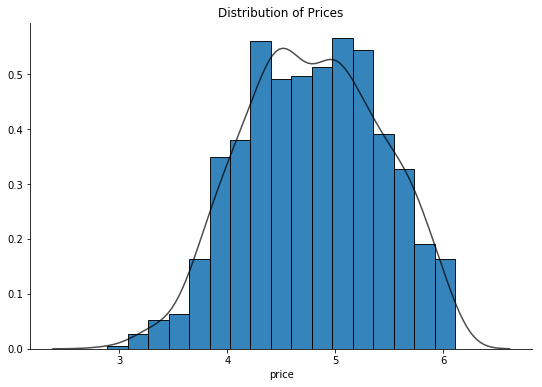

In [19]:
from statlearning import plot_histogram

plot_histogram(y_train)
plt.title('Distribution of Prices')
plt.show()

In [20]:
from sklearn.linear_model import RidgeCV

alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_scaled, y_train)

RidgeCV(alphas=[3.0517578125e-05, 3.5055491790680982e-05, 4.0268185753567341e-05, 4.6255998733837822e-05, 5.3134189654304478e-05, 6.103515625e-05, 7.0110983581361965e-05, 8.0536371507134683e-05, 9.2511997467675645e-05, 0.00010626837930860896, 0.0001220703125, 0.00014022196716272393, 0.00016107274301426937, ...05, 16384.0, 18820.273848271459, 21618.817610103131, 24833.500225706386, 28526.20085808741, 32768.0],
    cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

param_test1 = {'alpha':[4,4.1, 4.2, 4.3, 4.4, 4.5,4.6, 4.7, 4.8,5,5.5,6]}
gsearch1 = GridSearchCV(estimator = KernelRidge(kernel='polynomial', degree=2), 
                        param_grid = param_test1,cv=5)
gsearch1.fit(X_train_scaled, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

param_test2 = {'coef0':[1,1.5,2,2.5,3,4,5]}
gsearch2 = GridSearchCV(estimator = KernelRidge(alpha = 4.4, kernel='polynomial', degree=2), 
                        param_grid = param_test2,cv=5)
gsearch2.fit(X_train_scaled, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [21]:
KRR = KernelRidge(alpha = 4.4,  coef0 = 2, kernel='polynomial', degree = 2)
KRR.fit(X_train_scaled, y_train)

KernelRidge(alpha=4.4, coef0=2, degree=2, gamma=None, kernel='polynomial',
      kernel_params=None)

from statlearning import plot_coefficients
plot_coefficients(ridge._final_estimator, predictors)
plt.show()

In [22]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [23]:
from sklearn.linear_model import ElasticNetCV

enet = ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)
enet.fit(X_train_scaled, y_train)

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

from sklearn.ensemble import RandomForestRegressor
param_test1 = {'n_estimators':list(range(100,2000,200))}
gsearch1 = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=100,
                                  min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10), 
                        param_grid = param_test1,cv=5)
gsearch1.fit(X_train_scaled, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

param_test2 = {'max_depth':np.arange(3,14,2), 'min_samples_split':np.arange(50,201,20)}
gsearch2 = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 1000, 
                                  min_samples_leaf=20,max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test2,iid=False, cv=5)
gsearch2.fit(X_train_scaled, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 190, max_depth = 9, min_samples_split = 50, random_state = 1)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=50, min_weight_fraction_leaf=0.0,
           n_estimators=190, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [25]:
model_xgb = xgb.XGBRegressor(
    n_estimators=190,gamma = 0.4, colsample_bytree=0.8, max_depth = 3,min_child_weight = 5, subsample=0.8, reg_alpha=0.05)
model_xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=190, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

model = lgb.LGBMRegressor(objective='regression')


tuning_parameters = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators' : [190, 250, 300, 400, 500, 600, 750],
    'max_depth' : [3, 4],
    'subsample' : [0.8, 1.0],
}

gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 64, cv = 5, return_train_score=False, n_jobs=4, 
                               random_state = 20)

gb_search.fit(X_train_scaled, y_train)

lbst = gb_search.best_estimator_


print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

In [26]:
model_lgb = lgb.LGBMRegressor(objective='regression', n_estimators = 600, max_depth = 3, subsample  = 0.8, colsample_bytree=0.8, learning_rate = 0.01, random_state = 1)
model_lgb.fit(X_train_scaled, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       learning_rate=0.01, max_depth=3, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=1,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=1)

In [27]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_scaled)
    rmse= np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)


In [28]:
rmsle_cv(lasso).mean()

0.36410290090527042

In [29]:
rmsle_cv(KRR).mean()

0.37025804783524674

In [30]:
rmsle_cv(rf).mean()

0.37314424547235014

In [31]:
rmsle_cv(model_xgb).mean()

0.36401517777920051

In [32]:
rmsle_cv(model_lgb).mean()

0.36388013045202799

In [33]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [34]:
stacked_averaged_models = StackingAveragedModels(base_models = (enet, model_xgb, KRR, rf),
                                                 meta_model = lasso)

In [35]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [36]:
stacked_averaged_models.fit(X_train_scaled, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train_scaled)
xgb_pred = model_xgb.predict(X_train_scaled)
print(rmsle(y_train, stacked_train_pred))

0.29435431738


In [37]:
rf_pred = rf.predict(X_train_scaled)
lgb_pred = model_lgb.predict(X_train_scaled)
fit = stacked_train_pred*0.7 + xgb_pred*0.15 + lgb_pred * 0.15
pred = np.exp(fit)

In [38]:
print(rmsle(y_train,fit))

0.282810936647


In [39]:
stacked_averaged_models.meta_model_.coef_

array([ 0.48242175,  0.45966489,  0.07897793, -0.        ])

In [40]:
tdata = pd.read_csv('test.csv', index_col = "Id")
tdata = show_up_percentage(tdata, "room_type")
# tdata = show_up_percentage(tdata, "property_type")

In [41]:
tdata = pd.get_dummies(tdata)
tdata.drop(["property_type_Camper/RV","property_type_Castle","property_type_Chalet","property_type_Heritage hotel (India)",
                 "property_type_Island","property_type_Serviced apartment","property_type_Tent","property_type_Train",
                 "property_type_Yurt"], axis = 1, inplace = True)

In [42]:
tdata["cen_lon"] = cen_lon
tdata["cen_lat"] = cen_lat
df_distance = pd.DataFrame(tdata.apply(lambda x: calDistFromLonLat(x["longitude"], x["latitude"], x["cen_lon"], x["cen_lat"]), axis = 1))
df_distance.rename_axis({0:"distance"}, axis = 1, inplace = True)
tdata = tdata.join(df_distance)
tdata.drop([ "cen_lon", "cen_lat"], axis = 1, inplace = True)
tdata.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,...,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,is_business_travel_ready_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,distance
Id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-33.873078,151.245989,3,1.0,1.0,1.0,131.0,60.0,20,...,0,0,1,0,1,0,0,1,0,3.502952
1,1.0,-33.890010,151.260024,4,1.0,2.0,2.0,200.0,100.0,0,...,0,0,1,0,1,0,0,0,1,5.552310
2,1.0,-33.942177,151.260278,5,1.0,2.0,4.0,400.0,100.0,0,...,0,0,1,0,1,0,0,1,0,10.082166
3,1.0,-33.871542,151.228007,2,1.0,1.0,1.0,NaN,30.0,20,...,0,0,1,0,1,0,0,0,1,1.953943
4,52.0,-33.891067,151.267428,4,1.0,1.0,2.0,500.0,120.0,20,...,0,0,1,0,1,0,0,0,1,6.186318


In [43]:
def test_missing_security_deposit(df):
    process = df.drop(["cleaning_fee"], axis = 1)
    temp = process.pop("security_deposit")
    process.fillna(0,inplace = True)
    process.insert(0,"security_deposit", temp)
    know = process[process.security_deposit.notnull()].as_matrix()
    unknow = process[process.security_deposit.isnull()].as_matrix()
    x = know[:,1:]
    y = know[:,0]
    lgbna = lgb.LGBMRegressor(objective='regression', n_estimators = 600, subsample  = 0.8, learning_rate = 0.01)
    lgbna.fit(x,y)
    predicted = lgbna.predict(unknow[:,1:])
    df.loc[(df.security_deposit.isnull()), "security_deposit"] = predicted
    return df

def test_missing_cleaning_fee(df):
    process = df.drop(["security_deposit"], axis = 1)
    temp = process.pop("cleaning_fee")
    process.fillna(0,inplace = True)
    process.insert(0,"cleaning_fee", temp)
    know = process[process.cleaning_fee.notnull()].as_matrix()
    unknow = process[process.cleaning_fee.isnull()].as_matrix()
    x = know[:,1:]
    y = know[:,0]
    lgbna = lgb.LGBMRegressor(objective='regression', n_estimators = 600, subsample  = 0.8, learning_rate = 0.01)
    lgbna.fit(x,y)
    predicted = lgbna.predict(unknow[:,1:])
    df.loc[(df.cleaning_fee.isnull()), "cleaning_fee"] = predicted
    return df
tdata = test_missing_security_deposit(tdata)
tdata = test_missing_cleaning_fee(tdata)
tdata.fillna(0, inplace = True)
tdata.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,extra_people,...,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,is_business_travel_ready_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,distance
Id,,,,,,,,,,,,,,,,,,,,,
0,1.0,-33.873078,151.245989,3,1.0,1.0,1.0,131.000000,60.0,20,...,0,0,1,0,1,0,0,1,0,3.502952
1,1.0,-33.890010,151.260024,4,1.0,2.0,2.0,200.000000,100.0,0,...,0,0,1,0,1,0,0,0,1,5.552310
2,1.0,-33.942177,151.260278,5,1.0,2.0,4.0,400.000000,100.0,0,...,0,0,1,0,1,0,0,1,0,10.082166
3,1.0,-33.871542,151.228007,2,1.0,1.0,1.0,478.350607,30.0,20,...,0,0,1,0,1,0,0,0,1,1.953943
4,52.0,-33.891067,151.267428,4,1.0,1.0,2.0,500.000000,120.0,20,...,0,0,1,0,1,0,0,0,1,6.186318


In [44]:
# tdata["gap"] = np.sqrt(tdata["maximum_nights"] - tdata["minimum_nights"])
tdata["if_has_review"] = np.where(tdata["number_of_reviews"] == 0,0,1)
tdata["bedroom per people"] = tdata["bedrooms"]/tdata["accommodates"]
tdata["bathroom per people"] = tdata["bathrooms"]/tdata["accommodates"]
tdata["beds per people"] = tdata["beds"] / tdata["accommodates"]

In [45]:
tdata["accommodates"] = np.sqrt(tdata["accommodates"])
tdata["bathrooms"] = np.sqrt(tdata["bathrooms"])
tdata["minimum_nights"] = np.sqrt(tdata["minimum_nights"])
tdata["beds"] = np.sqrt(tdata["beds"])
tdata["number_of_reviews"] = np.sqrt(tdata["number_of_reviews"])
tdata["host_total_listings_count"] = np.sqrt(tdata["host_total_listings_count"])

In [46]:
tdata = filtering_region(tdata)

In [47]:
poly_data = tdata[["accommodates", "bathrooms", "bedrooms", "beds", "security_deposit","cancellation_policy_strict",
                 "cleaning_fee", "if_has_review","bedroom per people", "bathroom per people", "beds per people",
                 "distance", "host_is_superhost_t", "room_type_Entire home/apt", "extra_people",
                 "property_type_Bed & Breakfast","minimum_nights","review_scores_location",
                 "room_type_Private room", "room_type_Shared room","cancellation_policy_flexible"]]
poly = PolynomialFeatures(interaction_only=True)
df_poly = pd.DataFrame(poly.fit_transform(poly_data), columns=poly.get_feature_names(poly_data.columns))
df_poly = df_poly.iloc[:,22:]
tdata = tdata.join(df_poly)

In [48]:
X_test = tdata.copy()
scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

In [49]:
stacked_fit = stacked_averaged_models.predict(X_train_scaled)
xgb_fit = model_xgb.predict(X_train_scaled)
rf_fit = rf.predict(X_train_scaled)
lgb_fit = model_lgb.predict(X_train_scaled)
stacked_pred = stacked_averaged_models.predict(X_test_scaled)
xgb_pred = model_xgb.predict(X_test_scaled)
rf_pred = rf.predict(X_test_scaled)
lgb_pred = model_lgb.predict(X_test_scaled)
y_fit = ensemble = stacked_fit*0.7 + xgb_fit*0.15 + lgb_fit * 0.15
ensemble = stacked_pred*0.7 + xgb_pred*0.15 + lgb_pred * 0.15
y_pre = np.exp(ensemble)*np.mean(np.exp(y_train-y_fit))

In [50]:
sub = pd.read_csv('sampleSubmission.csv', index_col = "Id")
sub["price"] = y_pre
sub

,price
Id,
0,129.030374
1,220.416459
2,191.160923
3,154.404932
4,185.320611
5,109.179720
6,145.710542
7,138.499996
8,144.690003


sub.to_csv('Final.csv')